# Latents Exploration with Cutouts

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
#%matplotlib inline

from importlib import reload

import os
import numpy as np

import pandas
import xarray
import h5py

import torch
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import umap

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io
from ulmo.modis import analysis as analysis

## Load the data set

In [3]:
### Load data locally
tbl_file = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
### Load the data from s3 bucket
# tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(tbl_file)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


In [4]:
evals_tbl.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4


## Show one cutout samples

In [5]:
### Randomly sample one cutout
seed = 0
np.random.seed(seed)
index_rand = np.random.randint(0, 101)
cutout_M = evals_tbl.iloc[index_rand]
cutout_M

lat                                                         14.173034
lon                                                         49.783333
col                                                               780
datetime                                          2003-11-11 22:25:00
LL                                                          70.503662
row                                                              1055
clear_fraction                                               0.049561
mean_temperature                                            26.591866
Tmin                                                        25.219999
Tmax                                                        28.469999
T90                                                            27.795
T10                                                             25.82
filename                         AQUA_MODIS.20031111T222506.L2.SST.nc
UID                                               1068104173022978333
pp_file             

In [6]:
img_modis = modis_io.grab_image(cutout_M)

In [7]:
### set the plot of sns 
#sns.set_theme()
#sns.set_style('whitegrid')
#sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

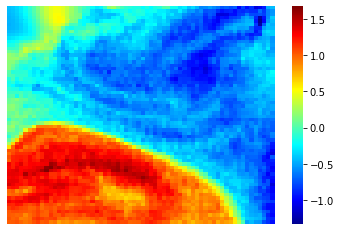

In [8]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
             cbar=True)

In [10]:
### Let's check the likelihood of above cutout
ll_cutout = evals_tbl.iloc[index_rand].LL
print('the likelihood of above cutout is: ', ll_cutout)

the likelihood of above cutout is:  70.503662109375


## Using Umap to reduce the dimension of Latents

In [11]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'
l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [12]:
from Latents_toolbox import *

In [13]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latent array!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values
ll_pd = evals_tbl[y2019].LL
assert ll_pd.shape[0] == latents.shape[0], "The 'll' list is not consistent with the latent array!"

The total number of latents is: 751689.


In [14]:
alpha = 0.99
left_outlier_indices, right_outlier_indices, normal_indices = outliers_preparing(ll_pd, alpha)
print(f'number of left outliers is: {len(left_outlier_indices)}.')
print(f'number of right outliers is: {len(right_outlier_indices)}.')
print(f'number of normal points is: {len(normal_indices)}.')

number of left outliers is: 3759.
number of right outliers is: 3759.
number of normal points is: 744171.


In [51]:
num_normal = len(left_outlier_indices)
seed = 0 
np.random.seed(seed)
samples_normal_indices = np.random.choice(normal_indices, num_normal, replace=False).squeeze()
samples_normal_indices = np.sort(samples_normal_indices)

In [16]:
left_outlier_latents = latents[left_outlier_indices]
right_outlier_latents = latents[right_outlier_indices]
normal_latents = latents[samples_normal_indices]

In [17]:
latents_sampled = np.concatenate((left_outlier_latents, right_outlier_latents, normal_latents), axis=0)
print(f'shape of the sampled latents is: {latents_sampled.shape}.')

shape of the sampled latents is: (11277, 512).


In [18]:
ll_left_outliers = ll_pd.iloc[left_outlier_indices].values
ll_right_outliers = ll_pd.iloc[right_outlier_indices].values
ll_normal = ll_pd.iloc[samples_normal_indices].values
ll_sampled = np.concatenate((ll_left_outliers, ll_right_outliers, ll_normal), axis=0)
print(f'shape of the sampled ll is: {ll_sampled.shape}')

shape of the sampled ll is: (11277,)


### Plot the UMap

In [19]:
n_neighbors = 200
min_dist = 0.3
n_components = 2
metric = 'euclidean'
title = f'min_dist is: {min_dist}'
parameters = {'n_neighbors': n_neighbors, 
              'min_dist': min_dist, 
              'n_components': n_components, 
              'metric': metric, 
              'title': title}

CPU times: user 15min 43s, sys: 54.5 s, total: 16min 38s
Wall time: 45.4 s


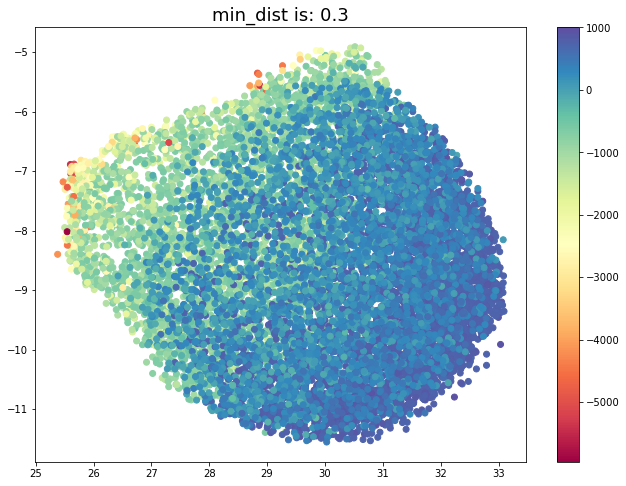

In [20]:
%%time
draw_umap(parameters, latents_sampled, ll_sampled)

In [21]:
n_neighbors = 500
min_dist = 0.3
n_components = 2
metric = 'euclidean'
title = f'min_dist is: {min_dist}'
parameters = {'n_neighbors': n_neighbors, 
              'min_dist': min_dist, 
              'n_components': n_components, 
              'metric': metric, 
              'title': title}

CPU times: user 24min 21s, sys: 1min 33s, total: 25min 54s
Wall time: 1min


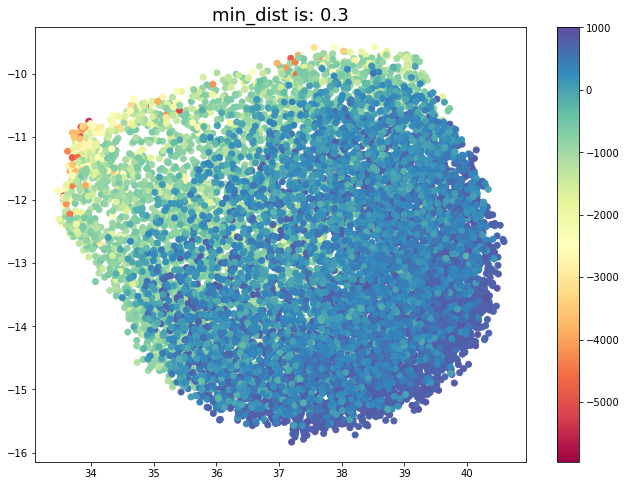

In [22]:
%%time
draw_umap(parameters, latents_sampled, ll_sampled)

## plot the scatter plot with cutout

In [33]:
n_neighbors = 500
min_dist = 0.3
n_components = 2
metric = 'euclidean'
title = f'min_dist is: {min_dist}'
parameters = {'n_neighbors': n_neighbors, 
              'min_dist': min_dist, 
              'n_components': n_components, 
              'metric': metric, 
              'title': title}

In [34]:
reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric)

In [35]:
reduced_latents = reducer.fit_transform(latents_sampled)

In [23]:
num_left = 3
num_right = 3
num_normal = 3

In [36]:
#left_samples_indices = np.random.choice(left_outlier_indices, num_left)
#right_samples_indices = np.random.choice(right_outlier_indices, num_right)
#normal_samples_indices = np.random.choice(samples_normal_indices, num_left)

In [52]:
left_samples_indices = left_outlier_indices[:3]
right_samples_indices = right_outlier_indices[:3]
normal_samples_indices = samples_normal_indices[:3]

In [89]:
left_coords = reduced_latents[:3, :]
right_coords = reduced_latents[len(left_outlier_indices): len(left_outlier_indices)+3, :]
normal_coords = reduced_latents[len(left_outlier_indices)+len(right_outlier_indices): len(left_outlier_indices)+len(right_outlier_indices)+3, :]

In [54]:
left_cutouts = evals_tbl.iloc[left_samples_indices]
right_cutouts = evals_tbl.iloc[right_samples_indices]
normal_cutouts = evals_tbl.iloc[normal_samples_indices]

In [55]:
imgs_left, imgs_right, imgs_normal = [], [], []
for i in range(num_left):
    imgs_left.append(modis_io.grab_image(left_cutouts.iloc[i]))
    imgs_right.append(modis_io.grab_image(right_cutouts.iloc[i]))
    imgs_normal.append(modis_io.grab_image(normal_cutouts.iloc[i]))

In [91]:
left_size = len(left_outlier_indices)
right_size = len(right_outlier_indices)
normal_size = len(samples_normal_indices)

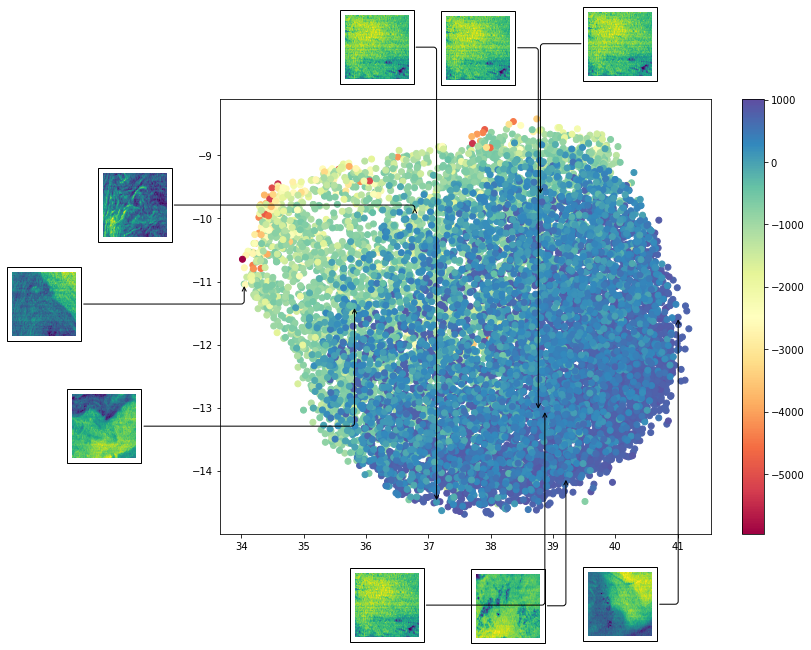

In [188]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=ll_sampled, cmap='Spectral')
plt.colorbar()
#for i in range(3):
################################## left 1 #################################################
xy = left_coords[0, :]
xbox, ybox = -280., +1.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_left[0], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
###########################################################################################
################################## left 2 #################################################
xy = left_coords[1, :]
xbox, ybox = -250., -120.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_left[1], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
##########################################################################################
################################## left 3 ################################################
xy = left_coords[2, :]
xbox, ybox = -200., -20.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_left[2], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
##########################################################################################
################################# right 1 ################################################
xy = right_coords[0, :]
xbox, ybox = -58., -128.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[0], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
##########################################################################################
################################ right 2 #################################################
xy = right_coords[1, :]
xbox, ybox = -58., -287.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[1], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
##########################################################################################
################################ right 3 #################################################
xy = right_coords[2, :]
xbox, ybox = -158., -195.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[2], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
###########################################################################################
################################ normal 1 #################################################
xy = normal_coords[0, :]
xbox, ybox = +80, +152.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[2], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
###########################################################################################
################################ normal 2 #################################################
xy = normal_coords[1, :]
xbox, ybox = -60, +363.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[2], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)
###########################################################################################
################################ normal 3 #################################################
xy = normal_coords[2, :]
xbox, ybox = -60, +455.
xybox = (xbox, ybox)
imagebox = OffsetImage(imgs_right[2], zoom=1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, xy, 
                    xybox, 
                    xycoords='data', 
                    boxcoords='offset points', 
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
ax.add_artist(ab)

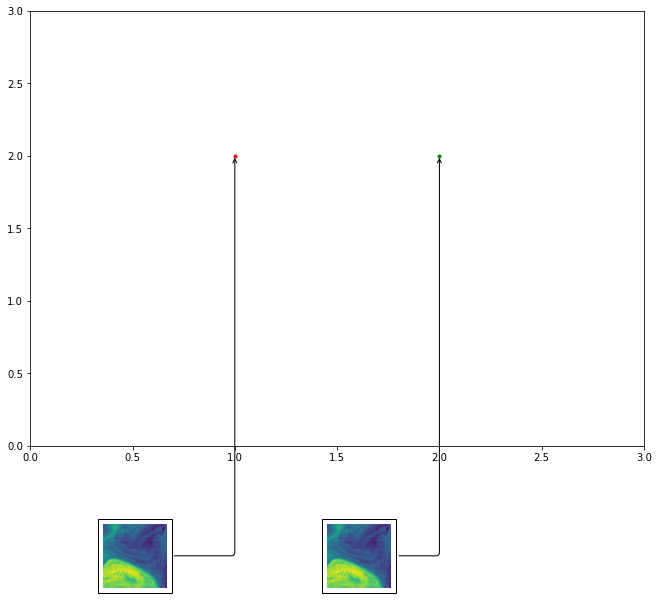

In [51]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

fig, ax = plt.subplots(figsize=(11, 8))
#xy = (1, 2)
#xy1 = (2, 2)
ax.sactter()
ax.plot(xy1[0], xy1[1], color='green', marker='.')

#imagebox = OffsetImage(img_modis, zoom=1)
#imagebox.image.axes = ax

#ab = AnnotationBbox(imagebox, xy, 
#                    xybox=(-100., -400), 
#                    xycoords='data', 
#                    boxcoords='offset points', 
#                    pad=0.5,
#                    arrowprops=dict(arrowstyle="->", 
#                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
#ax.add_artist(ab)

#ac = AnnotationBbox(imagebox, xy1, 
#                    xybox=(-80., -400), 
#                    xycoords='data', 
#                    boxcoords='offset points', 
#                    pad=0.5,
#                    arrowprops=dict(arrowstyle="->", 
#                                    connectionstyle="angle,angleA=0,angleB=90,rad=3"))
#ax.add_artist(ac)

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.show()